<a href="https://colab.research.google.com/github/MasaAsami/shap_no_use_for_causal/blob/main/notebooks/lalonde_cate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install -q optuna

In [42]:
# @title DMLを容易
import os
from contextlib import redirect_stdout
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm
from tqdm.notebook import tqdm

from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMClassifier, LGBMRegressor
from joblib import Parallel, delayed

class D2ML:
    """
    Doblue/Debiased Machine Learning
    """

    def __init__(
        self,
        data: pd.DataFrame,
        t_col: str,
        y_col: str,
        x_cols_for_t: list,
        x_cols_for_y: list,
        x_cols_for_cate: list,
        unit_id=None,
        t_model=LGBMClassifier(random_state=0),
        outcome_model=LGBMRegressor(random_state=0),
        cate_model=LGBMRegressor(random_state=0),
        n_bootstrap_samples=100,
    ):
        # params
        self._ate = None
        self._att = None
        self._bootstrap_ate = []
        self._bootstrap_att = []
        self.df_dml = None
        self.data = data
        self.t_col = t_col
        self.y_col = y_col
        self.x_cols_for_t = x_cols_for_t
        self.x_cols_for_y = x_cols_for_y
        self.x_cols_for_cate = x_cols_for_cate
        self.unit_id = unit_id
        self.n_bootstrap_samples = n_bootstrap_samples
        # model
        self.t_model = t_model
        self.outcome_model = outcome_model
        self.cate_model = cate_model
        self.ate_model_result = None
        self.explainer = None

    def fit_ate(
        self, eps=1e-3, cv=5, return_ate=False, bootstrap_data=pd.DataFrame([])
    ):
        if len(bootstrap_data) < 1:
            df_dml = self.data.copy()
        else:
            df_dml = bootstrap_data.copy()

        # t model for T residual
        df_dml = df_dml.assign(
            t_pred=np.clip(
                cross_val_predict(
                    self.t_model,
                    df_dml[self.x_cols_for_t],
                    df_dml[self.t_col],
                    cv=cv,
                    method="predict_proba",
                )[:, 1],
                eps,
                1 - eps,
            )
        )
        df_dml = df_dml.assign(
            t_res=df_dml[self.t_col] - df_dml["t_pred"],  # T residual
        )

        # y model for Y residual
        df_dml = df_dml.assign(
            y_res=df_dml[self.y_col]
            - cross_val_predict(
                self.outcome_model, df_dml[self.x_cols_for_y], df_dml[self.y_col], cv=cv
            ),
        )

        if self.unit_id == None:
            final_model = smf.ols(formula="y_res ~ t_res", data=df_dml).fit()
        else:
            final_model = smf.ols(formula="y_res ~ t_res", data=df_dml).fit(
                cov_type="cluster", cov_kwds={"groups": df_dml[self.unit_id]}
            )

        if return_ate:
            return final_model.params["t_res"], df_dml
        else:
            self._ate = final_model.params["t_res"]
            df_dml["ate"] = self._ate
            self.ate_model_result = final_model
            self.df_dml = df_dml

    def sim_bootstrap(self, eps=1e-3, cv=5, result_return=False):
        """
        Simulate bootstrap samples for ATE and ATT with parallel processing.
        """
        self._bootstrap_ate = []
        self._bootstrap_att = []

        _n = len(self.data)

        def bootstrap_task(i):
            """
            Perform a single bootstrap task.
            """
            _df_dml = self.data.sample(n=_n, replace=True, random_state=i).reset_index(drop=True)
            with redirect_stdout(open(os.devnull, "w")):
                _ate, _df_dml = self.fit_ate(eps=eps, cv=cv, return_ate=True, bootstrap_data=_df_dml)

            _att = self.fit_nonlinear_cate(return_att=True, bootstrap_data=_df_dml)
            return _ate, _att

        # Parallel processing with tqdm for progress display
        results = Parallel(n_jobs=-1)(
            delayed(bootstrap_task)(i) for i in tqdm(range(self.n_bootstrap_samples), desc="Bootstrap")
        )

        # Collect results
        for _ate, _att in results:
            self._bootstrap_ate.append(_ate)
            self._bootstrap_att.append(_att)

        self._att = np.mean(self._bootstrap_att)
        self._ate = np.mean(self._bootstrap_ate)  # rewrite ate

        if result_return:
            return self._bootstrap_ate, self._bootstrap_att


    def stderr(self, effect_type="ate"):
        if len(self._bootstrap_ate) == 0:
            self.sim_bootstrap()
        if effect_type == "ate":
            return np.std(self._bootstrap_ate)
        else:
            return np.std(self._bootstrap_att)

    def summary(self, alpha=0.05, effect_type="ate"):
        assert effect_type in ["ate", "att"]
        if self._ate == None:
            self.fit_ate()

        stderr = self.stderr(effect_type=effect_type)

        if effect_type == "ate":
            _effect = self._ate
        else:
            _effect = self._att

        z_stat = (_effect - 0) / stderr
        p_value = norm.sf(np.abs(z_stat), loc=0, scale=1) * 2
        # confidence interval
        ci_lower = norm.ppf(alpha / 2, loc=_effect, scale=stderr)
        ci_higher = norm.ppf(1 - alpha / 2, loc=_effect, scale=stderr)
        return pd.DataFrame(
            {
                "effect": _effect,
                "standard_error": stderr,
                "z_stat": z_stat,
                "p_value": p_value,
                f"CI {alpha}": ci_lower,
                f"CI {1-alpha}": ci_higher,
            },
            index=["t"],
        )

    def fit_linear_cate(self, linear_cate_Xcols=None):
        if self._ate == None:
            self.fit_ate()

        if linear_cate_Xcols == None:
            linear_cate_Xcols = self.x_cols_for_cate

        formula = "y_res ~ t_res*("
        formula += "+".join(linear_cate_Xcols)
        formula += ")"

        if self.unit_id == None:
            cate_linear_model = smf.ols(formula, data=self.df_dml).fit()
        else:
            cate_linear_model = smf.ols(formula, data=self.df_dml).fit(
                cov_type="cluster", cov_kwds={"groups": self.df_dml[self.unit_id]}
            )
        print("Warning: This STANDARD ERROR is not accurate!")
        print(cate_linear_model.summary().tables[1])

        self.df_dml = self.df_dml.assign(
            linear_cate=cate_linear_model.predict(self.df_dml.assign(t_res=1))
            - cate_linear_model.predict(self.df_dml.assign(t_res=0)),
        )

    def fit_nonlinear_cate(
        self, cap_att=True, return_att=False, bootstrap_data=pd.DataFrame([])
    ):
        if self._ate == None:
            self.fit_ate()

        if len(bootstrap_data) == 0:
            df_dml = self.df_dml.copy()
        else:
            df_dml = bootstrap_data.copy()

        model_weight = df_dml["t_res"] ** 2  # 残差の二乗
        cate_model_y = df_dml["y_res"] / df_dml["t_res"]  # 新しい教師ラベル

        self.cate_model.fit(
            X=df_dml[self.x_cols_for_cate], y=cate_model_y, sample_weight=model_weight
        )

        df_dml = df_dml.assign(
            non_linear_cate=self.cate_model.predict(df_dml[self.x_cols_for_cate])
        )
        # df_dml = df_dml.assign(
        #     non_linear_cate= cross_val_predict(
        #         self.cate_model, df_dml[self.x_cols_for_cate], cate_model_y, cv=cv, fit_params={"sample_weight":model_weight}
        #         )
        #     )
        if cap_att:
            q_low = df_dml["non_linear_cate"].quantile(0.01)
            q_hi = df_dml["non_linear_cate"].quantile(0.99)
            df_dml["non_linear_cate"] = df_dml["non_linear_cate"].clip(
                lower=q_low, upper=q_hi
            )

        if return_att:
            return df_dml.query(f"{self.t_col} > 0")["non_linear_cate"].mean()
        else:
            self.df_dml = df_dml

In [43]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, ElasticNetCV, LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# Seaborn のスタイルとコンテキストを設定
sns.set_style("ticks")          # クリーンなスタイル
sns.set_context("paper")        # 論文用のコンテキスト設定

In [44]:
RCT_DATA = "http://www.nber.org/~rdehejia/data/nsw_dw.dta"
CPS_DATA = "http://www.nber.org/~rdehejia/data/cps_controls3.dta"  # cps_controls3 cps調査で直前に無職だったものに限定


In [45]:
rct_df = pd.read_stata(RCT_DATA )
del rct_df["data_id"]

rct_df["treat"] = rct_df["treat"].astype(int)
rct_df.head()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,1,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,1,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,1,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,1,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [46]:
def p_value_color(df):
    styles = df.copy()
    styles.iloc[:, :] = ""
    idx_ = df["p_value"] <= 0.05
    styles.loc[idx_, :] = "color:purple"
    return styles

In [47]:
base_values = [col for col in rct_df.columns if col != "treat"]
_pivot = pd.pivot_table(
    rct_df,
    columns="treat",
    values=base_values,
    # margins=True,
    aggfunc=["count", np.mean, np.std],
)
_pivot["t_statistic"] = 0
_pivot["p_value"] = 0

for _value in base_values:
    _stat, _p = stats.ttest_ind(
        *rct_df.dropna(subset=[_value])
        .groupby("treat")[_value]
        .apply(lambda x: list(x)),
        equal_var=False
    )
    _pivot.loc[_value, "t_statistic"] = _stat
    _pivot.loc[_value, "p_value"] = _p

_pivot.style.apply(p_value_color, axis=None)

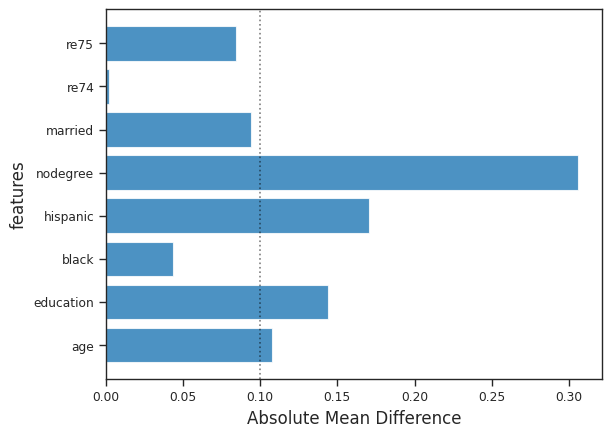

In [48]:
# 分析前の共変量バランス
def cal_abs_mean_diff(df):
    # (treatment群の平均 - control群の平均) / 全体の標準誤差
    return (
        (
            df.query("treat>0").drop("treat", axis=1).mean()
            - df.query("treat<1").drop("treat", axis=1).mean()
        )
        / df.drop("treat", axis=1).std()
    ).abs()


# 調整前のAbsolute Mean Difference
unadjusted_balance = rct_df[
    [
        "treat",
        "age",
        "education",
        "black",
        "hispanic",
        "nodegree",
        "married",
        "re74",
        "re75",
    ]
]
unadjusted_balance = cal_abs_mean_diff(unadjusted_balance)

fig, ax = plt.subplots()

ax.set_xlabel("Absolute Mean Difference", fontsize=12)
ax.set_ylabel("features", fontsize=12)
ax.barh(unadjusted_balance.index, unadjusted_balance, alpha=0.8)
ax.axvline(x=0.1, alpha=0.5, color="black", linestyle="dotted")
plt.show()

In [49]:
# multi regression
all_featuers = [col for col in rct_df.columns if "re78" not in col]

multi_formula = "re78 ~ "
for i, _featuer in enumerate(all_featuers):
    if i == 0:
        multi_formula += f"{_featuer}"
    else:
        multi_formula += f" + {_featuer}"
print(multi_formula)

rct_multi_regression = smf.ols(multi_formula, data=rct_df).fit()
print(rct_multi_regression.summary())

re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re75
                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.804
Date:                Wed, 25 Dec 2024   Prob (F-statistic):            0.00329
Time:                        15:33:10   Log-Likelihood:                -4534.2
No. Observations:                 445   AIC:                             9088.
Df Residuals:                     435   BIC:                             9129.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [50]:
rct_effect = rct_multi_regression.params["treat"]
print("rct_effect : ", rct_effect)

rct_effect :  1676.3426254026253


In [51]:
df = pd.concat(
    [
        pd.read_stata(RCT_DATA).query("treat>0"),  # (失業者介入実験データ)nsw data の介入群のみ抽出
        pd.read_stata(CPS_DATA),
    ]
).reset_index(drop=True)

del df["data_id"]

df["treat"] = df["treat"].astype(int)
df.sample(10)

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
27,1,27.0,10.0,0.0,1.0,0.0,1.0,0.000000,0.000000,11142.870117
105,1,43.0,9.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
204,0,35.0,9.0,0.0,0.0,1.0,1.0,11475.429688,9397.403320,11087.379883
132,1,26.0,11.0,1.0,0.0,1.0,1.0,0.000000,1392.853027,1460.359985
254,0,28.0,10.0,0.0,0.0,1.0,1.0,10415.459961,5544.628906,10289.410156
580,0,48.0,14.0,0.0,0.0,1.0,0.0,0.000000,0.000000,7236.426758
296,0,28.0,13.0,0.0,0.0,0.0,0.0,5260.630859,3790.113037,9253.524414
313,0,23.0,12.0,0.0,0.0,1.0,0.0,7856.660156,3213.628906,5535.563965
532,0,19.0,12.0,0.0,1.0,0.0,0.0,1058.004028,0.000000,8923.991211
76,1,22.0,12.0,1.0,0.0,0.0,0.0,0.000000,0.000000,18678.080078


In [52]:
base_values = [col for col in df.columns if col != "treat"]
_pivot = pd.pivot_table(
    df,
    columns="treat",
    values=base_values,
    # margins=True,
    aggfunc=["count", np.mean, np.median, np.std],
)
_pivot["t_statistic"] = 0
_pivot["p_value"] = 0

for _value in base_values:
    _stat, _p = stats.ttest_ind(
        *df.dropna(subset=[_value])
        .groupby("treat")[_value]
        .apply(lambda x: list(x)),
        equal_var=False
    )
    _pivot.loc[_value, "t_statistic"] = _stat
    _pivot.loc[_value, "p_value"] = _p

_pivot.style.apply(p_value_color, axis=None)

In [53]:
y_col = "re78"
d_col = "treat"
X_cols = [col for col in df.columns if col not in [d_col , y_col]]

In [54]:
# 一旦ハイパーパラメータを探しに行く
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
# Generate synthetic regression data
X = df[X_cols]
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

def objective(trial):
    """Objective function for Optuna to optimize LGBMRegressor hyperparameters."""
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-4, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-4, 10.0),
    }

    model = LGBMRegressor(**params, random_state=0, verbosity=-1)

    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    return -np.mean(scores)

# Run the optimization with Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_params_reg = study.best_params
best_model = LGBMRegressor(**best_params_reg, random_state=0)
best_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error:", mse)

[I 2024-12-25 15:33:11,457] A new study created in memory with name: no-name-95eed75d-dec7-47af-b33f-0eff815b1d4d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-25 15:33:12,861] Trial 0 finished with value: 49892409.85867379 and parameters: {'num_leaves': 292, 'max_depth': 11, 'learning_rate': 0.0030962461529253755, 'n_estimators': 378, 'min_child_samples': 11, 'subsample': 0.56599103467706, 'colsample_bytree': 0.8827726197556682, 'reg_alpha': 0.21221711796924514, 'reg_lambda': 4.091248327696654}. Best is trial 0 with value: 49892409.85867379.
[I 2024-12-25 15:33:13,229] Trial 1 finished with value: 50234666.94263138 and parameters: {'num_leaves': 403, 'max_depth': 5, 'learning_rate': 0.06114809787736853, 'n_estimators': 113, 'min_child_samples': 22, 'subsample': 0.6404736795911548, 'colsample_bytree': 0.7495643448296321, 'reg_alpha': 0.03107692225082695, 'reg_lambda': 0.5968477495901504}. Best is trial 0 with value: 49892409.85867379.
[I 2024-12-25 15:33:14,226] Trial 2 finished with value: 49901732.046996355 and parameters: {'num_leaves': 194, 'max_depth': 7, 'learning_rate': 0.009472344715079427, 'n_estimators': 402, 'min_child_s

In [55]:
from sklearn.metrics import log_loss, make_scorer, roc_auc_score
X = df[X_cols]
y = df[d_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def optimize_lgbm(trial, X_train, y_train):
    """
    Objective function to optimize LGBMClassifier hyperparameters using Optuna.
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
    }

    # Initialize the model
    clf = LGBMClassifier(random_state=0, class_weight="balanced", **params)

    # Negative log loss as scoring
    scorer = make_scorer(roc_auc_score, greater_is_better=False, needs_proba=True)

    # Cross-validation scoring
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')

    # Return mean log loss (negative value because Optuna minimizes by default)
    return -np.mean(scores)

def run_optimization(X_train, y_train, n_trials=10):
    """
    Run Optuna optimization for LGBMClassifier.
    """
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: optimize_lgbm(trial, X_train, y_train), n_trials=n_trials)
    return study

# Example usage:
study = run_optimization(X_train, y_train, n_trials=100)
best_params_clf = study.best_params
print("Best Hyperparameters:", best_params_clf)

[I 2024-12-25 15:34:00,946] A new study created in memory with name: no-name-338225c2-60de-4838-8f51-e478599aaaf1
[I 2024-12-25 15:34:01,211] Trial 0 finished with value: -0.8927757352941177 and parameters: {'n_estimators': 114, 'learning_rate': 0.1655711544010611, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 67, 'subsample': 0.8508624203157731, 'colsample_bytree': 0.9345219870851774, 'reg_alpha': 0.06313023693710076, 'reg_lambda': 0.0021500132113256463}. Best is trial 0 with value: -0.8927757352941177.
[I 2024-12-25 15:34:01,425] Trial 1 finished with value: -0.8920343137254904 and parameters: {'n_estimators': 69, 'learning_rate': 0.016658025668344394, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 41, 'subsample': 0.8913071152154577, 'colsample_bytree': 0.9040127963421589, 'reg_alpha': 1.5746654048772497, 'reg_lambda': 0.941377266958219}. Best is trial 0 with value: -0.8927757352941177.
[I 2024-12-25 15:34:02,147] Trial 2 finished with value: -0.8844975490196079 an

Best Hyperparameters: {'n_estimators': 144, 'learning_rate': 0.034045445030731515, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8445312870725117, 'colsample_bytree': 0.7528740542248058, 'reg_alpha': 0.010222581808440183, 'reg_lambda': 0.0016455208999216187}


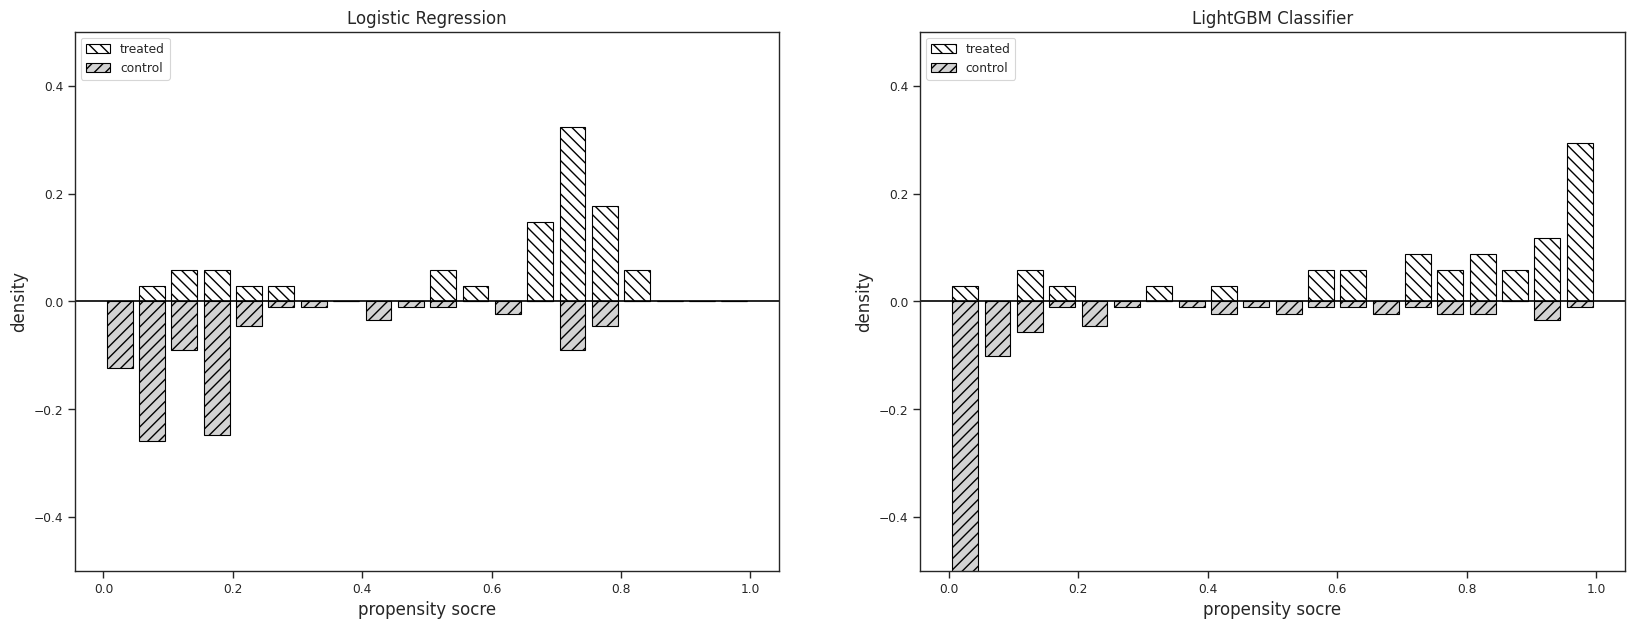

In [56]:
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, ElasticNetCV, LogisticRegression, LinearRegression
X = df[X_cols]
y = df[d_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf_lgbm = LGBMClassifier(**best_params_clf, random_state=0,class_weight="balanced").fit(X_train, y_train)

X_test["ps"] = clf.predict_proba(X_test[X_cols])[:, 1]
X_test["ps_lgbm"] = clf_lgbm.predict_proba(X_test[X_cols])[:, 1]

fig, ax = plt.subplots(ncols=2, figsize=(20, 7))
# それぞれの値を調節
plt.subplots_adjust(wspace=0.2)
ps0 = X_test.ps[y_test == 0]
ps1 = X_test.ps[y_test == 1]

bins = np.arange(0, 1.05, 0.05)
hist0, _ = np.histogram(ps0, bins=bins)
hist1, _ = np.histogram(ps1, bins=bins)
hist0 = hist0 / sum(hist0)
hist1 = hist1 / sum(hist1)
ax[0].bar(bins[:-1] + 0.025, hist1, width=0.04, color="white", edgecolor="black", hatch="\\\\\\", label="treated")
ax[0].bar(bins[:-1] + 0.025, -hist0, width=0.04, color="lightgray", edgecolor="black", hatch="///", label="control")
ax[0].axhline(0, c="black")
ax[0].set_ylabel("density", fontsize=12)
ax[0].set_ylim([-0.5, 0.5])
ax[0].set_title("Logistic Regression", fontsize=12)
ax[0].set_xlabel("propensity socre", fontsize=12)
ax[0].legend(loc='upper left')

ps0 = X_test.ps_lgbm[y_test == 0]
ps1 = X_test.ps_lgbm[y_test == 1]

bins = np.arange(0, 1.05, 0.05)
hist0, _ = np.histogram(ps0, bins=bins)
hist1, _ = np.histogram(ps1, bins=bins)
hist0 = hist0 / sum(hist0)
hist1 = hist1 / sum(hist1)
ax[1].bar(bins[:-1] + 0.025, hist1, width=0.04, color="white", edgecolor="black", hatch="\\\\\\", label="treated")
ax[1].bar(bins[:-1] + 0.025, -hist0, width=0.04, color="lightgray", edgecolor="black", hatch="///", label="control")
ax[1].axhline(0, c="black")
ax[1].set_ylabel("density", fontsize=12)
ax[1].set_ylim([-0.5, 0.5])
ax[1].set_title("LightGBM Classifier", fontsize=12)
ax[1].set_xlabel("propensity socre", fontsize=12)
ax[1].legend(loc='upper left')
plt.savefig("lalonde_common_support.png", format="png", dpi=300)
plt.show()

In [57]:
dml = D2ML(
    data=df,
    t_col=d_col,
    y_col=y_col,
    x_cols_for_t=X_cols,
    x_cols_for_y=X_cols,
    x_cols_for_cate=X_cols,
    t_model=LGBMClassifier(**best_params_clf, random_state=0, class_weight="balanced"),
    outcome_model=LGBMRegressor(**best_params_reg, random_state=0),
    cate_model=LGBMRegressor(**best_params_reg, random_state=0),
    n_bootstrap_samples=100,
)

In [58]:
dml.fit_ate(cv=5)
dml.fit_nonlinear_cate()
dml.summary(effect_type="att")

Bootstrap:   0%|          | 0/100 [00:00<?, ?it/s]

,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,1081.905098,1219.34856,0.887281,0.374928,-1307.974164,3471.784359


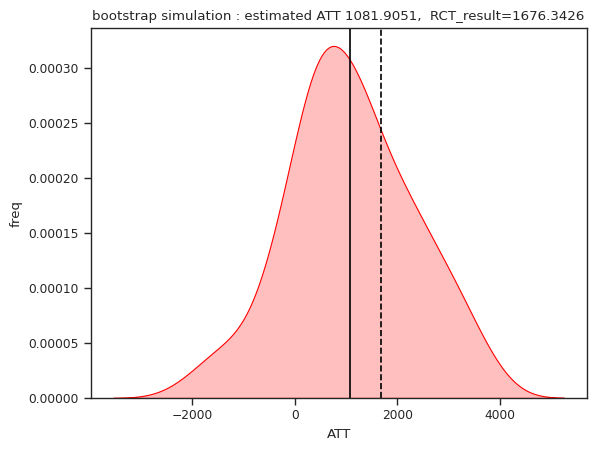

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sns.kdeplot(dml._bootstrap_att,shade=True, color='red', ax=ax)
ax.set_title(
    f"bootstrap simulation : estimated ATT {dml._att:.4f},  RCT_result={rct_effect:.4f}"
)
ax.set_xlabel("ATT")
ax.set_ylabel("freq")
ax.axvline(x=dml._att, color="black")
ax.axvline(x=rct_effect, color="black", linestyle="--")
fig.show()

In [60]:
import shap

shap.initjs()

df_dml_result = dml.df_dml.query(f"treat > 0").sort_values(by="non_linear_cate")
cate_model = dml.cate_model
explainer = shap.TreeExplainer(cate_model)

shap_values = explainer.shap_values(df_dml_result[dml.x_cols_for_cate])

In [61]:
print(df_dml_result.non_linear_cate.mean())
df_dml_result

1025.0117713932543


,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,t_pred,t_res,y_res,ate,non_linear_cate
172,1,20.0,9.0,0.0,1.0,0.0,1.0,12260.780273,5875.048828,1358.642944,0.005458,0.994542,-5344.921914,-459.820084,-5744.951462
175,1,28.0,11.0,1.0,0.0,0.0,1.0,1929.029053,6871.855957,0.000000,0.016138,0.983862,-8161.790020,-459.820084,-4465.882909
179,1,29.0,10.0,0.0,1.0,0.0,1.0,0.000000,8853.673828,5112.014160,0.092915,0.907085,-3338.651484,-459.820084,-3418.546471
128,1,23.0,12.0,0.0,1.0,0.0,0.0,9385.740234,1117.438965,559.443176,0.006572,0.993428,-5395.819667,-459.820084,-3403.412806
163,1,29.0,10.0,1.0,0.0,0.0,1.0,0.000000,4398.950195,0.000000,0.237500,0.762500,-7751.702122,-459.820084,-3207.022497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1,27.0,12.0,1.0,0.0,0.0,0.0,2143.413086,357.949890,22163.250000,0.236918,0.763082,17071.689469,-459.820084,5583.470429
132,1,26.0,11.0,1.0,0.0,1.0,1.0,0.000000,1392.853027,1460.359985,0.673902,0.326098,-3785.920787,-459.820084,5928.605784
125,1,27.0,9.0,1.0,0.0,1.0,1.0,0.000000,934.445374,1773.422974,0.553128,0.446872,-4142.782714,-459.820084,7003.946808
131,1,28.0,11.0,1.0,0.0,0.0,1.0,0.000000,1284.078979,60307.929688,0.740780,0.259220,53510.758156,-459.820084,7029.254088


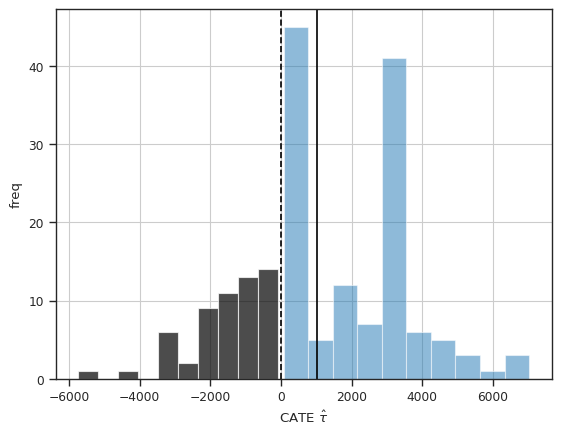

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
df_dml_result.query("non_linear_cate >= 0").non_linear_cate.hist(ax=ax, alpha=0.5)
df_dml_result.query("non_linear_cate < 0").non_linear_cate.hist(ax=ax, color="black", alpha=0.7)
ax.axvline(x=0, color="black", ls="--")
ax.axvline(x=df_dml_result.non_linear_cate.mean(), color="black")
ax.set_xlabel("CATE $\hat τ$")
ax.set_ylabel("freq")
plt.savefig("lalonde_cate_hist.png", format="png", dpi=300)
fig.show()

In [63]:
print(f"失敗率: {100*len(df_dml_result.query('non_linear_cate < 0')) / len(df_dml_result) :.3f}%")

失敗率: 30.811%


In [64]:
df_dml_result.query("re75==0 and re74==0")["non_linear_cate"].mean()

1854.9851118500314

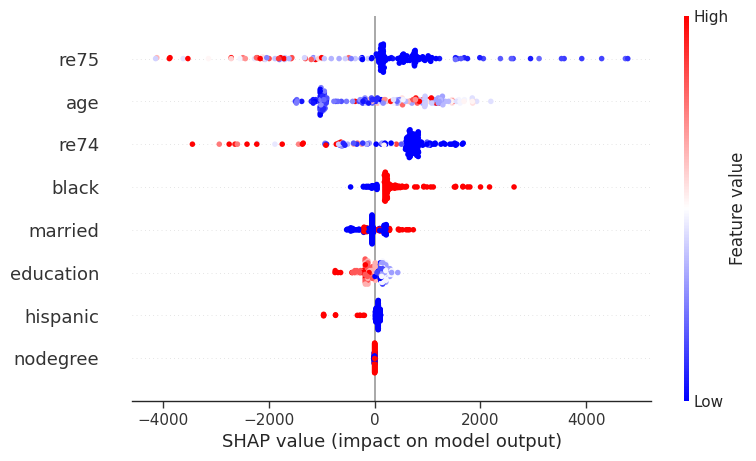

In [65]:
shap.summary_plot(shap_values, df_dml_result[dml.x_cols_for_cate], cmap='bwr')

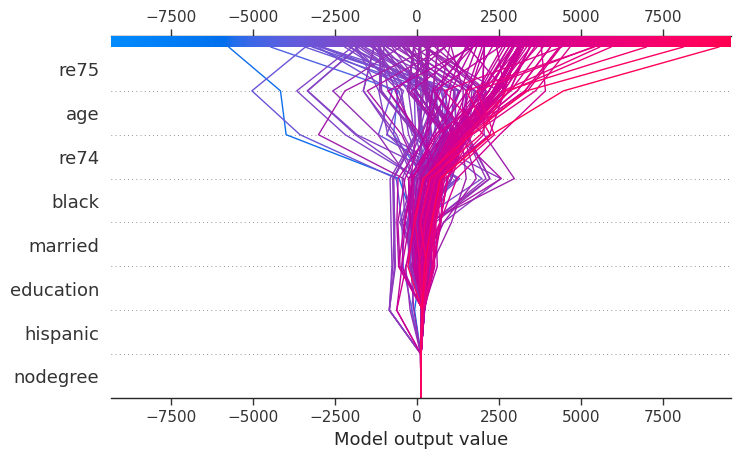

In [66]:
shap.decision_plot(
    explainer.expected_value, shap_values,  df_dml_result[dml.x_cols_for_cate]
)

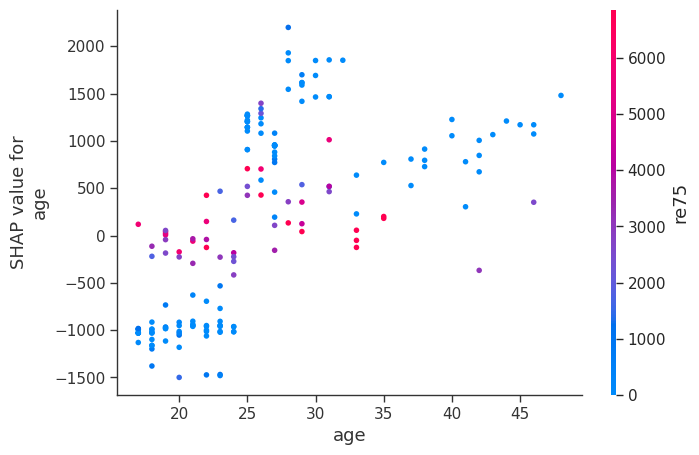

In [67]:
shap.dependence_plot(
    "age", shap_values, df_dml_result[dml.x_cols_for_cate], display_features=df_dml_result[dml.x_cols_for_cate], interaction_index="re75"
)

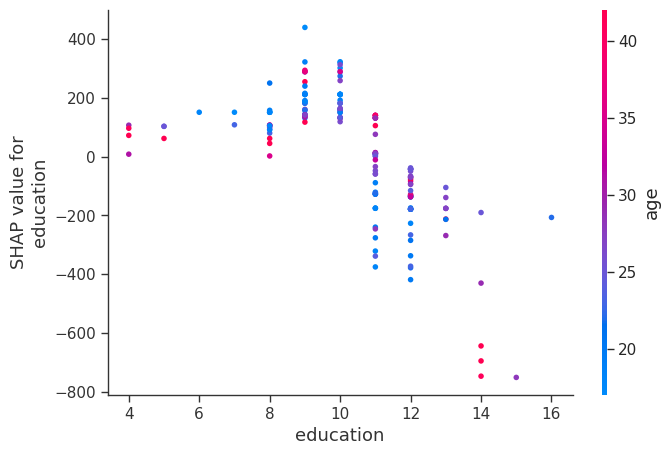

In [68]:
shap.dependence_plot(
    "education", shap_values, df_dml_result[dml.x_cols_for_cate], display_features=df_dml_result[dml.x_cols_for_cate], interaction_index="age"
)

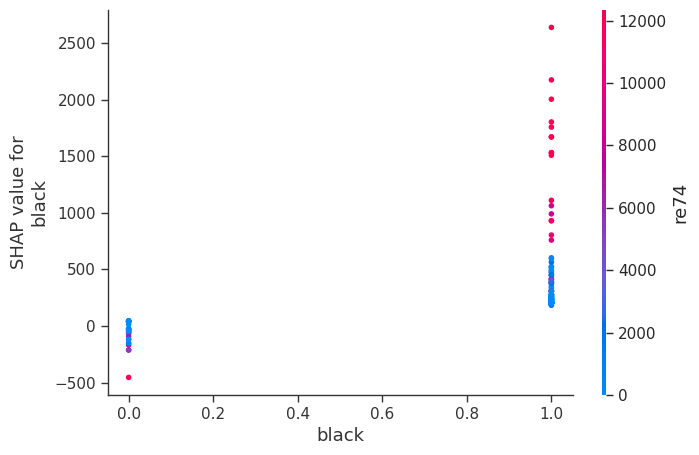

In [69]:
shap.dependence_plot(
    "black", shap_values, df_dml_result[dml.x_cols_for_cate], display_features=df_dml_result[dml.x_cols_for_cate]
)

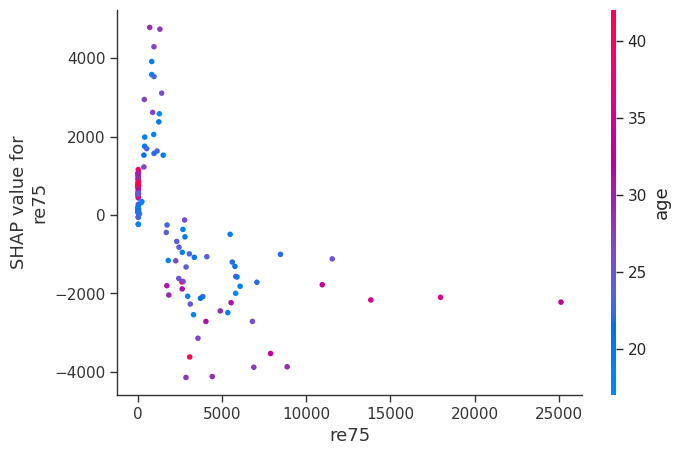

In [70]:
shap.dependence_plot(
    "re75", shap_values, df_dml_result[dml.x_cols_for_cate], display_features=df_dml_result[dml.x_cols_for_cate]
)

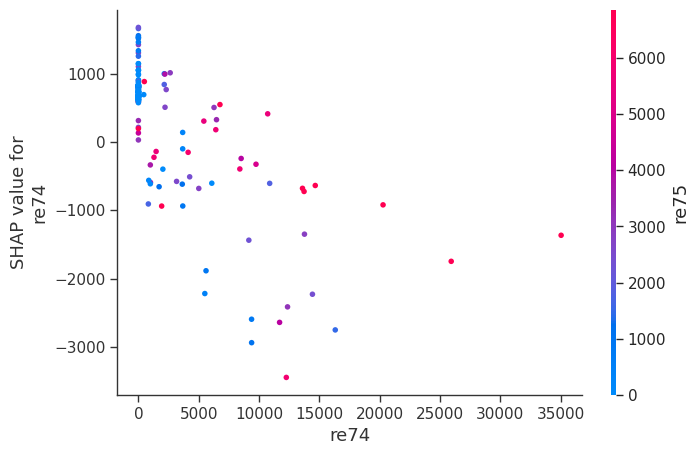

In [71]:
shap.dependence_plot(
    "re74", shap_values, df_dml_result[dml.x_cols_for_cate], display_features=df_dml_result[dml.x_cols_for_cate]
)

In [72]:
shap_df = pd.DataFrame(shap_values, columns= dml.x_cols_for_cate)

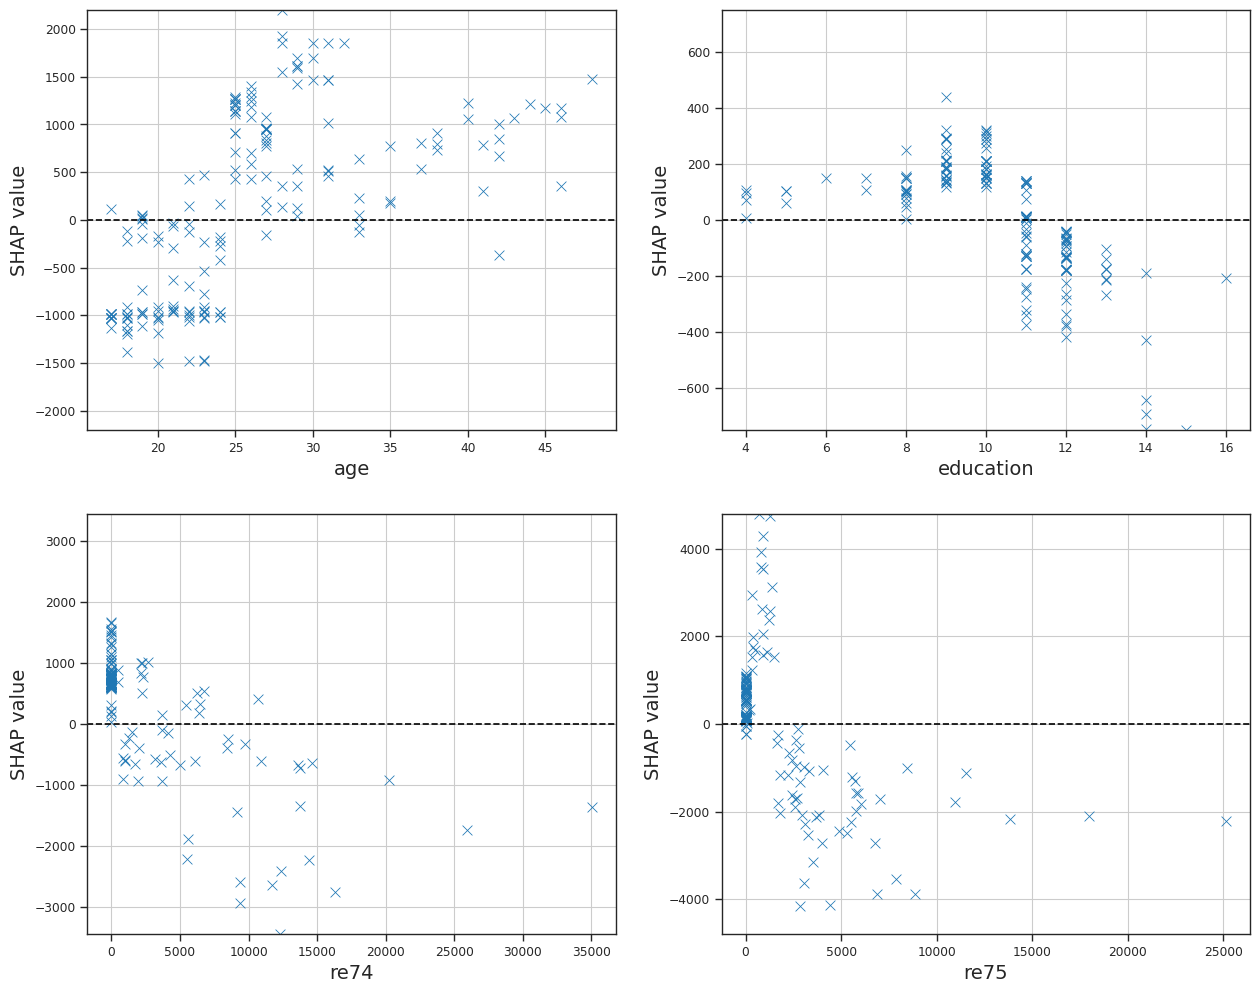

In [73]:
shap_cols = ["age", "education", "re74", "re75"]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flat

for i, _col in enumerate(shap_cols):
    sns.scatterplot(
        x=df_dml_result[_col].values,
        y=shap_df[_col].values,
        marker="x",
        #color="black",
        s=50,
        ax=axes[i],
        label=""
    )
    axes[i].axhline(y=0, color="black", ls="--")
    # y軸の最大値と最小値を取得
    y_max = max(abs(shap_df[_col].max()), abs(shap_df[_col].min()))
    axes[i].set_ylim(-y_max, y_max)
    axes[i].set_xlabel(f"{_col}", fontsize=14)
    axes[i].set_ylabel(f"SHAP value", fontsize=14)
    axes[i].grid()
plt.savefig("lalonde_shap.png", format="png", dpi=300)
plt.show()
